In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from random import choice
import random
import networkx as nx
import os
from pandas.io.json import json_normalize

In [258]:
# SET CHANNEL PREFERENCES
connectedness_percentile = 99
num_channels_to_make = 3
channel_capacity_sats = 20000

In [259]:
# GET DATA
lightning_dir = "~/lightning/cli/"
save_dir = "> /Users/dariuscognac/Documents/GitHub/Lightning-Network-Topological-Analysis/"
listnodes = lightning_dir + "lightning-cli listnodes" + save_dir + "list_of_nodes.json"
listchannels = lightning_dir + "lightning-cli listchannels" + save_dir + "list_of_channels.json"

# os.system(listnodes);
# os.system(listchannels);


# LOAD AND FORMAT DATA
nodes_temp = pd.read_json('list_of_nodes.json')
nodes_table = json_normalize(nodes_temp['nodes'])

channels_temp = pd.read_json('list_of_channels.json')
channels_table = json_normalize(channels_temp['channels'])


# MAKE GRAPH
G = nx.Graph()
G.add_nodes_from(nodes_table['nodeid'])
edges_list = [(channels_table['source'][i], channels_table['destination'][i]) for i in range(len(channels_table))]
G.add_edges_from(edges_list)

print('Number of nodes = ' + str(len(G.nodes())))
print('Number of edges (payment channels) = ' + str(len(G.edges())))
print('\n\n')

# Get just the main graph
def get_main_subgraph(G):
    all_sub_G = list(nx.connected_component_subgraphs(G))
    largest_sg = 0
    for i, sg in enumerate(all_sub_G):
        if sg.number_of_nodes() > largest_sg:
            largest_sg = sg.number_of_nodes()
            main_G = sg
    return main_G


# Define find_nodes_with_highest_deg_cent()
def find_nodes_high_percentile_deg_cent(G, connectedness_percentile):
    # Compute the degree centrality of G: deg_cent      
    deg_cent = nx.degree_centrality(G)
    # Compute the X percentile of degree centrality
    dc = list(deg_cent.values())
    high_percentile_dc = np.percentile(dc, connectedness_percentile)
    nodes = set()
    # Iterate over the degree centrality dictionary
    for k, v in deg_cent.items():
        # Check if the current value has the maximum degree centrality
        if v > high_percentile_dc:
            # Add the current node to the set of nodes
            nodes.add(k)
    return nodes

# PICK NEW NEIGHBORS
# Remove disconnected nodes
G = get_main_subgraph(G)
# Find nodes within top X% of highest centrality
potential_neighbors = list(find_nodes_high_percentile_deg_cent(G, connectedness_percentile))
# pick new neighbors
new_neighbors = random.sample(potential_neighbors, num_channels_to_make)


# DISPLAY NEW NEIGHBOR INFO
print("Do you want to connect to the following nodes?\n\n")
node_alias=[]; num_channels=[]; ip_address=[]

for i in range(len(new_neighbors)):
    nd = nodes_table[nodes_table['nodeid']==new_neighbors[i]]
    node_alias.append(str(nd['alias']))
    num_channels.append(len(list(G.neighbors(new_neighbors[i]))))
    ip_address.append(list(nd['addresses'])[0][0]['address'])
    print("node ID: "+new_neighbors[i])
    print("node alias: "+node_alias[i])
    print("number of channels: "+str(num_channels[i])+"\n")

Number of nodes = 4117
Number of edges (payment channels) = 4917



Do you want to connect to the following nodes?


node ID: 03bb88ccc444534da7b5b64b4f7b15e1eccb18e102db0e400d4b9cfe93763aa26d
node alias: 2592    LightningTo.Me
Name: alias, dtype: object
number of channels: 108

node ID: 03cb7983dc247f9f81a0fa2dfa3ce1c255365f7279c8dd143e086ca333df10e278
node alias: 3576    fairly.cheap
Name: alias, dtype: object
number of channels: 194

node ID: 02ad6fb8d693dc1e4569bcedefadf5f72a931ae027dc0f0c544b34c1c6f3b9a02b
node alias: 2304    rompert.com🔵
Name: alias, dtype: object
number of channels: 251



In [260]:
# CREATE NEW GRAPH WITH NEW NODE AND EDGES
G_new = get_main_subgraph(G)
G_new.add_node('new_node')
new_edges = [('new_node',i) for i in new_neighbors]
G_new.add_edges_from(new_edges)


In [287]:
# DRAW NEW GRAPHS

def plot_ego_graph(new_node_id):
    # Create ego graphs
    ego_graph = nx.ego_graph(G_new, new_node_id, radius=2)
    immediate_graph = nx.ego_graph(G_new, new_node_id, radius=1)


    bb = nx.degree_centrality(G_new)


    plt.figure(3,figsize=(12,8)) 
    pos=nx.spring_layout(ego_graph, seed=1)


    # Draw larger extended network 
    graph1_color_vals = [bb.get(node) for node in ego_graph.nodes()]

    nx.draw_networkx_nodes(ego_graph, pos=pos, cmap=plt.get_cmap('viridis'), 
            node_color=graph1_color_vals, node_size=100, alpha=0.6)
    nx.draw_networkx_edges(ego_graph, pos=pos, alpha=0.3, edge_color='grey')


    # Draw immediate network with stronger alpha
    graph2_color_vals = [bb.get(node) for node in immediate_graph.nodes()]

    nx.draw(immediate_graph, pos=pos, cmap=plt.get_cmap('viridis'), with_labels = False, 
            node_color=graph2_color_vals, node_size=400, alpha=1, edge_color='k', width = 5)


    # Create label for new node
    labels = {}    
    for node in immediate_graph.nodes():
        if node == new_node_id:
            #set the node name as the key and the label as its value 
            labels[node] = 'Your node'

    # offset new label
    offset =-.1
    pos_labels = {}
    keys = pos.keys()
    for key in keys:
        x, y = pos[key]
        pos_labels[key] = (x, y+offset)
    nx.draw_networkx_labels(immediate_graph, pos_labels, labels, font_size=15, font_color='b', font_weight='bold')
    plt.show()



/Users/dariuscognac/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/Users/dariuscognac/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


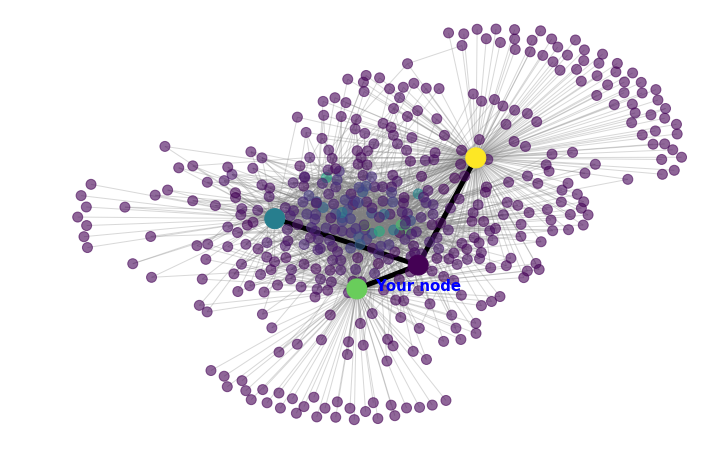

In [288]:
plot_ego_graph('new_node')

In [4]:
# CONNECT TO SELECTED NODES
for i in range(len(new_neighbors)):

    print("Setting up payment channel with "+node_alias[i]+"\n");
    connect = lightning_dir+"lightning-cli connect "+new_neighbors[i]+"@"+ip_address[i]
    print(connect)
#     os.system(connect);

    fund_channel = lightning_dir+"lightning-cli fundchannel "+new_neighbors[i]+" "+str(channel_capacity_sats)
    print(fund_channel)
    print("\n")
#     os.system(fund_channel);
    

Setting up payment channel with 1756    1ML.com node ALPHA
Name: alias, dtype: object

~/lightning/cli/lightning-cli connect 0217890e3aad8d35bc054f43acc00084b25229ecff0ab68debd82883ad65ee8266@23.237.77.11
~/lightning/cli/lightning-cli fundchannel 0217890e3aad8d35bc054f43acc00084b25229ecff0ab68debd82883ad65ee8266 20000


Setting up payment channel with 2592    LightningTo.Me
Name: alias, dtype: object

~/lightning/cli/lightning-cli connect 03bb88ccc444534da7b5b64b4f7b15e1eccb18e102db0e400d4b9cfe93763aa26d@138.68.14.104
~/lightning/cli/lightning-cli fundchannel 03bb88ccc444534da7b5b64b4f7b15e1eccb18e102db0e400d4b9cfe93763aa26d 20000


Setting up payment channel with 3281    btc.lnetwork.tokyo
Name: alias, dtype: object

~/lightning/cli/lightning-cli connect 028dcc199be86786818c8c32bffe9db8855c5fca98951eec99d1fa335d841605c2@153.126.136.98
~/lightning/cli/lightning-cli fundchannel 028dcc199be86786818c8c32bffe9db8855c5fca98951eec99d1fa335d841605c2 20000


